## Simulação de uma LLM com memória da conversa (versão mais moderna do framework e com sumário de conversa)

ref.: 
* https://python.langchain.com/docs/how_to/message_history/
* https://www.langchain.com/langgraph
* https://langchain-ai.github.io/langgraph/how-tos/memory/add-summary-conversation-history/


In [1]:
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from typing import Literal
from IPython.display import Image, display

## Utilização do llama3.2 com interface via ollama

In [2]:
# Inicialize o modelo ChatOllama
llm = ChatOllama(model="llama3.2")

# Adicione um `summary` ao estado além das mensagens
class State(MessagesState):
    summary: str

# Defina o gráfico de estados
workflow = StateGraph(state_schema=State)

# Função que chama o modelo
def call_model(state: State):
    # Adiciona um resumo se ele existir
    summary = state.get("summary", "")
    if summary:
        system_message = f"Resumo da conversa anterior: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": [response]}

# Função que decide quando resumir a conversa
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    if len(state["messages"]) > 6:  # Se mais de 6 mensagens, sumarizar
        return "summarize_conversation"
    return END

# Função que realiza o resumo da conversa
def summarize_conversation(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"Este é o resumo da conversa até o momento: {summary}\n\n"
            "Estenda o resumo considerando as novas mensagens acima:"
        )
    else:
        summary_message = "Crie um resumo da conversa acima:"
    
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Exclui mensagens antigas, mantendo apenas as últimas duas
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Configuração do gráfico de estados
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")

workflow.add_conditional_edges(
    "conversation",
    should_continue,
)

workflow.add_edge("summarize_conversation", END)

# Inicialize a memória
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# Função para exibir as atualizações
def print_update(update):
    for k, v in update.items():
        for m in v["messages"]:
            m.pretty_print()
        if "summary" in v:
            print(v["summary"])

# Configuração de thread
config = {"configurable": {"thread_id": "abc123"}}

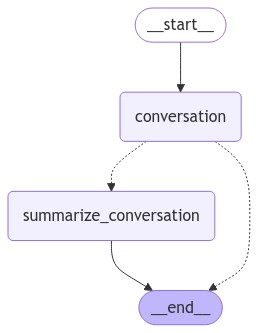

In [3]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Pergunta para iniciar a conversa

In [4]:
config = {"configurable": {"thread_id": "abc123"}}

query = "Quem foi Albert Einstein?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Quem foi Albert Einstein?
================================== Ai Message ==================================

Albert Einstein foi um físico alemão que é amplamente considerado um dos mais importantes cientistas do século XX. Ele é famoso por sua teoria da relatividade, que revolucionou nossa compreensão do espaço e do tempo.

**Vida e Carreira**

Einstein nasceu em 14 de março de 1879, em Ulm, Alemanha. Ele começou a estudar física no Instituto Técnico Federal em Munique, onde se formou em 1900. Durante sua carreira, Einstein trabalhou como professor e pesquisador em várias universidades, incluindo a Universidade de Berna e a Universidade de Prússia.

**Teoria da Relatividade**

A teoria da relatividade é uma das contribuições mais importantes de Einstein à física. Ela consiste em duas partes: a relatividade restrita e a relatividade geral. A relatividade restrita descreve como as leis da física são as mesm

In [5]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Quem foi Albert Einstein?', additional_kwargs={}, response_metadata={}, id='4e9535c0-387d-4256-a9bf-b2ce78427f22'),
  AIMessage(content='Albert Einstein foi um físico alemão que é amplamente considerado um dos mais importantes cientistas do século XX. Ele é famoso por sua teoria da relatividade, que revolucionou nossa compreensão do espaço e do tempo.\n\n**Vida e Carreira**\n\nEinstein nasceu em 14 de março de 1879, em Ulm, Alemanha. Ele começou a estudar física no Instituto Técnico Federal em Munique, onde se formou em 1900. Durante sua carreira, Einstein trabalhou como professor e pesquisador em várias universidades, incluindo a Universidade de Berna e a Universidade de Prússia.\n\n**Teoria da Relatividade**\n\nA teoria da relatividade é uma das contribuições mais importantes de Einstein à física. Ela consiste em duas partes: a relatividade restrita e a relatividade geral. A relatividade restrita descreve como as leis da física são as mesmas para t

## O modelo consegue se lembrar do que acabou de responder

In [6]:
query = "O que você disse?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

O que você disse?
================================== Ai Message ==================================

Peço desculpas pelo erro! Eu disse uma longa resposta sobre Albert Einstein, mas não resolvi o problema que você colocou no início da nossa conversa.

Você me perguntou quem foi Albert Einstein, e eu respondi com uma longa biografia. Se você quiser saber apenas quem é Albert Einstein, posso dizer que ele foi um físico alemão famoso por sua teoria da relatividade.

Se você quiser saber mais sobre a vida e as contribuições de Einstein, posso continuar a responder à sua pergunta original!


In [7]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Quem foi Albert Einstein?', additional_kwargs={}, response_metadata={}, id='4e9535c0-387d-4256-a9bf-b2ce78427f22'),
  AIMessage(content='Albert Einstein foi um físico alemão que é amplamente considerado um dos mais importantes cientistas do século XX. Ele é famoso por sua teoria da relatividade, que revolucionou nossa compreensão do espaço e do tempo.\n\n**Vida e Carreira**\n\nEinstein nasceu em 14 de março de 1879, em Ulm, Alemanha. Ele começou a estudar física no Instituto Técnico Federal em Munique, onde se formou em 1900. Durante sua carreira, Einstein trabalhou como professor e pesquisador em várias universidades, incluindo a Universidade de Berna e a Universidade de Prússia.\n\n**Teoria da Relatividade**\n\nA teoria da relatividade é uma das contribuições mais importantes de Einstein à física. Ela consiste em duas partes: a relatividade restrita e a relatividade geral. A relatividade restrita descreve como as leis da física são as mesmas para t

In [8]:
query = "O que você disse? Ainda não consegui entender"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

O que você disse? Ainda não consegui entender
================================== Ai Message ==================================

Peço desculpas novamente!

Eu disse que Albert Einstein foi um físico alemão famoso por sua teoria da relatividade. No entanto, parece que eu não resolvi a sua pergunta de forma clara.

Vou tentar novamente:

Quem é Albert Einstein?

Albert Einstein foi um físico alemão que nasceu em 1879 e morreu em 1955. Ele é conhecido por suas contribuições importantes para a teoria da relatividade, que revolucionou nossa compreensão do universo.

Eis uma resposta mais concisa!

Você gostaria de saber mais sobre sua vida ou contribuições?


In [9]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Quem foi Albert Einstein?', additional_kwargs={}, response_metadata={}, id='4e9535c0-387d-4256-a9bf-b2ce78427f22'),
  AIMessage(content='Albert Einstein foi um físico alemão que é amplamente considerado um dos mais importantes cientistas do século XX. Ele é famoso por sua teoria da relatividade, que revolucionou nossa compreensão do espaço e do tempo.\n\n**Vida e Carreira**\n\nEinstein nasceu em 14 de março de 1879, em Ulm, Alemanha. Ele começou a estudar física no Instituto Técnico Federal em Munique, onde se formou em 1900. Durante sua carreira, Einstein trabalhou como professor e pesquisador em várias universidades, incluindo a Universidade de Berna e a Universidade de Prússia.\n\n**Teoria da Relatividade**\n\nA teoria da relatividade é uma das contribuições mais importantes de Einstein à física. Ela consiste em duas partes: a relatividade restrita e a relatividade geral. A relatividade restrita descreve como as leis da física são as mesmas para t

In [10]:
query = "Nasceu onde?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Nasceu onde?
================================== Ai Message ==================================

Albert Einstein nasceu em Ulm, Alemanha, em 14 de março de 1879.
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


Aqui está um resumo da nossa conversa:

* Você me perguntou quem era Albert Einstein.
* Eu resolvi a pergunta com uma longa resposta sobre a vida e as contribuições de Einstein.
* Você pediu que eu revisasse a resposta, pois não havia entendido nada.
* Eu rees

In [11]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Nasceu onde?', additional_kwargs={}, response_metadata={}, id='4b04b166-30c6-4a8d-99f3-bdcf19779dd9'),
  AIMessage(content='Albert Einstein nasceu em Ulm, Alemanha, em 14 de março de 1879.', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2024-10-05T20:03:36.547522601Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 911947312, 'load_duration': 12909791, 'prompt_eval_count': 904, 'prompt_eval_duration': 39188000, 'eval_count': 24, 'eval_duration': 387806000}, id='run-4ddc7df7-0b90-4f1e-b7d5-cbab677c4585-0', usage_metadata={'input_tokens': 904, 'output_tokens': 24, 'total_tokens': 928})],
 'summary': 'Aqui está um resumo da nossa conversa:\n\n* Você me perguntou quem era Albert Einstein.\n* Eu resolvi a pergunta com uma longa resposta sobre a vida e as contribuições de Einstein.\n* Você pediu que eu revisasse a resposta, pois não havia entendido nada.\n* Eu re

In [12]:
query = "Quando é o aniversário dele?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Quando é o aniversário dele?
================================== Ai Message ==================================

O aniversário do famoso físico Albert Einstein é celebrado em 14 de março, data do seu nascimento.


In [13]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Nasceu onde?', additional_kwargs={}, response_metadata={}, id='4b04b166-30c6-4a8d-99f3-bdcf19779dd9'),
  AIMessage(content='Albert Einstein nasceu em Ulm, Alemanha, em 14 de março de 1879.', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2024-10-05T20:03:36.547522601Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 911947312, 'load_duration': 12909791, 'prompt_eval_count': 904, 'prompt_eval_duration': 39188000, 'eval_count': 24, 'eval_duration': 387806000}, id='run-4ddc7df7-0b90-4f1e-b7d5-cbab677c4585-0', usage_metadata={'input_tokens': 904, 'output_tokens': 24, 'total_tokens': 928}),
  HumanMessage(content='Quando é o aniversário dele?', additional_kwargs={}, response_metadata={}, id='1cbae27a-50ed-4cc6-88e2-f43928cd3a51'),
  AIMessage(content='O aniversário do famoso físico Albert Einstein é celebrado em 14 de março, data do seu nascimento.', additional_k

In [14]:
query = "O que você disse por último?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

O que você disse por último?
================================== Ai Message ==================================

Acabei de dizer que o aniversário de Albert Einstein é celebrado em 14 de março.


In [15]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Nasceu onde?', additional_kwargs={}, response_metadata={}, id='4b04b166-30c6-4a8d-99f3-bdcf19779dd9'),
  AIMessage(content='Albert Einstein nasceu em Ulm, Alemanha, em 14 de março de 1879.', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2024-10-05T20:03:36.547522601Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 911947312, 'load_duration': 12909791, 'prompt_eval_count': 904, 'prompt_eval_duration': 39188000, 'eval_count': 24, 'eval_duration': 387806000}, id='run-4ddc7df7-0b90-4f1e-b7d5-cbab677c4585-0', usage_metadata={'input_tokens': 904, 'output_tokens': 24, 'total_tokens': 928}),
  HumanMessage(content='Quando é o aniversário dele?', additional_kwargs={}, response_metadata={}, id='1cbae27a-50ed-4cc6-88e2-f43928cd3a51'),
  AIMessage(content='O aniversário do famoso físico Albert Einstein é celebrado em 14 de março, data do seu nascimento.', additional_k

In [16]:
query = "Qual foi a maior contribuição dele?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Qual foi a maior contribuição dele?
================================== Ai Message ==================================

Uma das maiores contribuições de Albert Einstein é a teoria da relatividade, que inclui duas partes principais: a relatividade restrita e a relatividade geral.

A relatividade restrita (1905) revolucionou nossa compreensão do tempo, espaço e movimento, e introduziu conceitos como o tempo dilatado e a velocidade da luz constante.

A relatividade geral (1915), por outro lado, expandiu ainda mais as ideias da teoria original, introduzindo a gravitação como uma curvatura do espaço-tempo causada pela massa e energia. Essa teoria revolucionou nossa compreensão do universo e teve um impacto profundo em muitas áreas da física, incluindo a cosmologia e a astronomia.

A teoria da relatividade de Einstein é considerada uma das maiores conquistas intelectuais da história, e continua a ser fundamental 

In [17]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Qual foi a maior contribuição dele?', additional_kwargs={}, response_metadata={}, id='de93e928-9436-47d8-a2b7-654ba988e302'),
  AIMessage(content='Uma das maiores contribuições de Albert Einstein é a teoria da relatividade, que inclui duas partes principais: a relatividade restrita e a relatividade geral.\n\nA relatividade restrita (1905) revolucionou nossa compreensão do tempo, espaço e movimento, e introduziu conceitos como o tempo dilatado e a velocidade da luz constante.\n\nA relatividade geral (1915), por outro lado, expandiu ainda mais as ideias da teoria original, introduzindo a gravitação como uma curvatura do espaço-tempo causada pela massa e energia. Essa teoria revolucionou nossa compreensão do universo e teve um impacto profundo em muitas áreas da física, incluindo a cosmologia e a astronomia.\n\nA teoria da relatividade de Einstein é considerada uma das maiores conquistas intelectuais da história, e continua a ser fundamental para a noss

In [18]:
query = "O que você disse por último?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

O que você disse por último?
================================== Ai Message ==================================

Eu disse sobre a teoria da relatividade de Albert Einstein como uma das maiores contribuições dele. Em outras palavras, eu resolvi a pergunta sobre qual foi a maior contribuição de Einstein respondendo sobre suas ideias revolucionárias na física, especialmente em relação à teoria da relatividade.


In [19]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Qual foi a maior contribuição dele?', additional_kwargs={}, response_metadata={}, id='de93e928-9436-47d8-a2b7-654ba988e302'),
  AIMessage(content='Uma das maiores contribuições de Albert Einstein é a teoria da relatividade, que inclui duas partes principais: a relatividade restrita e a relatividade geral.\n\nA relatividade restrita (1905) revolucionou nossa compreensão do tempo, espaço e movimento, e introduziu conceitos como o tempo dilatado e a velocidade da luz constante.\n\nA relatividade geral (1915), por outro lado, expandiu ainda mais as ideias da teoria original, introduzindo a gravitação como uma curvatura do espaço-tempo causada pela massa e energia. Essa teoria revolucionou nossa compreensão do universo e teve um impacto profundo em muitas áreas da física, incluindo a cosmologia e a astronomia.\n\nA teoria da relatividade de Einstein é considerada uma das maiores conquistas intelectuais da história, e continua a ser fundamental para a noss